# KI-Projekt mit Swisscom Randdaten

Google MyMaps

https://www.google.com/maps/d/edit?mid=1apMhJHAyxVrtAY3oitbtkdKem6wQyLE&usp=sharing


Um ein Python-Programm zu schreiben, das eine CSV-Datei mit Adressen (Smartphone-Netzverbindungen) verarbeitet, die Koordinaten für diese Adressen abruft und die Koordinaten wieder in eine CSV-Datei schreibt, benötigen wir die zwei Bibliotheken geopy und csv.
Installation mit <code>pip install geopy</code> bzw. <code>pip install csv</code>.

<iframe src="https://www.google.com/maps/d/embed?mid=1apMhJHAyxVrtAY3oitbtkdKem6wQyLE&hl=de&ehbc=2E312F" width="640" height="480"></iframe>

In [ ]:
import csv
from geopy.geocoders import Nominatim

def geocode_address(address):
    geolocator = Nominatim(user_agent="geo_coder")
    location = geolocator.geocode(address)
    if location is not None:
        return location.latitude, location.longitude
    else:
        return None, None

def main():
    input_csv_file = "input.csv"
    output_csv_file = "coordinates.csv"

    with open(input_csv_file, 'r', encoding='utf-8') as infile, open(output_csv_file, 'w', newline='') as outfile:
        csv_reader = csv.reader(infile)
        csv_writer = csv.writer(outfile)        
    
        for row in csv_reader:
            address = row[0]  # Die Adresse steht in der ersten Spalte der CSV-Datei
            month = row[1]
            latitude, longitude = geocode_address(address)
            
            # Schreibe die Adresse und die Koordinaten in die CSV-Ausgabedatei
         
            if latitude is not None and longitude is not None:
                csv_writer.writerow([latitude, longitude, month])
                #print(f"Address: {address}, Latitude: {latitude}, Longitude: {longitude}")
                print(f"{latitude}, {longitude}, {month}")
           
if __name__ == "__main__":
    main()


In [6]:
# Zeige die ersten Zeilen des Data Frames
import pandas as pd
df = pd.read_csv('coordinates.csv', header=None, names=['Latitude', 'Longitude', 'Month'])
df.head()

,Latitude,Longitude,Month
0,47.520634,7.679655,Mai
1,47.530287,7.660281,Mai
2,47.527399,7.647946,Mai
3,47.530287,7.660281,Mai
4,47.530287,7.660281,Mai


Wir möchten nun die 5'800 Datenpunkte verwenden, um vorherzusagen, wo und wann wir uns an einem beliebigen Punkt in der Schweiz befinden.
Für diese Machine-Learning-Aufgabe benötigen wir verschiedene Python-Bibliotheken wie Pandas, Matplotlib, NumPy, Scikit-learn und Keras.

Das folgende Script liest die CSV-Datei, wandelt die Monate in numerische Werte um, trainiert den k-nearest neighbor (KNN) Algorithmus mit den Daten und zeichnet die resultierenden Bereiche auf der Karte. Ausserdem gibt es die Genauigkeit des Modells aus. Wir können die Anzahl der Nachbarn im KNN-Algorithmus anpassen und sehen, wie sich das auf die Genauigkeit und die berechneten Bereiche auswirkt.

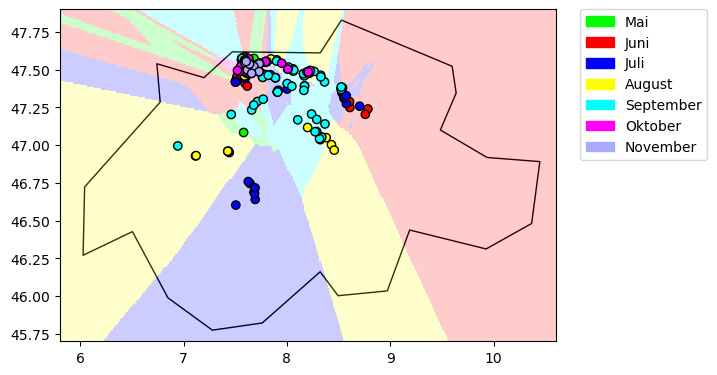

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.36      0.50      0.42        10
           3       0.60      0.38      0.46         8
           4       0.40      0.33      0.36        12
           5       0.30      0.18      0.22        17
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         0

    accuracy                           0.25        60
   macro avg       0.24      0.20      0.21        60
weighted avg       0.30      0.25      0.27        60



In [36]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from shapely.geometry import Point
import numpy as np
import matplotlib.patches as mpatches
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

# Daten lesen
df = pd.read_csv('coordinates.csv', header=None, names=['Latitude', 'Longitude', 'Month'])

# Monate in numerische Werte umwandeln
months = {'Mai':1, 'Juni':2, 'Juli':3, 'August':4, 'September':5, 'Oktober':6, 'November':7}
df['Month'] = df['Month'].map(months)

# Duplikate entfernen
df.drop_duplicates(inplace=True)

# Aufteilen der Daten, Modell trainieren
X = df[['Longitude', 'Latitude']].values
y = df['Month']

# Aufsplitten der Daten in Traininigs- (80%) und Testdaten (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Hier können die Anzahl der Nachbarn im KNN-Algorithmus angepasst werden,
# um zu sehen, wie sich das auf die Genauigkeit und die berechneten Bereiche auswirkt.
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Schweizer Karte hinzufügen
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
sw = world[world.name == 'Switzerland']
ax = sw.plot(color='white', edgecolor='black')

# Gitter für die gesamte Karte erstellen
h = .01
x_min, x_max = 5, 11
y_min, y_max = 45, 48
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Vorhersagen für jeden Punkt auf dem Gitter
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Setzen Sie Farben für die Karte
colors_list = ['#00FF00', '#FF0000', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#AAAAFF']
mpl.cmap_light = ListedColormap(colors_list)

# Karte zeichnen
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.2, axes=ax)

# Daten auf der Karte plotten
plt.scatter(df['Longitude'], df['Latitude'], c=df['Month'], cmap=cmap_light, edgecolor='black')

# Legende hinzufügen
patches = [mpatches.Patch(color=icolor, label=imonth) for icolor, imonth in zip(colors_list, months.keys())]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(5.8, 10.6)
plt.ylim(45.7, 47.9)
plt.show()

# Auswertung des Modells
# Klassifikationsbericht, der die Genauigkeit, Präzision, Recall und f1-score für jedes Label (Monat) ausgibt.
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

Variante des KNN-Algorithmus ohne Schweizerkarte

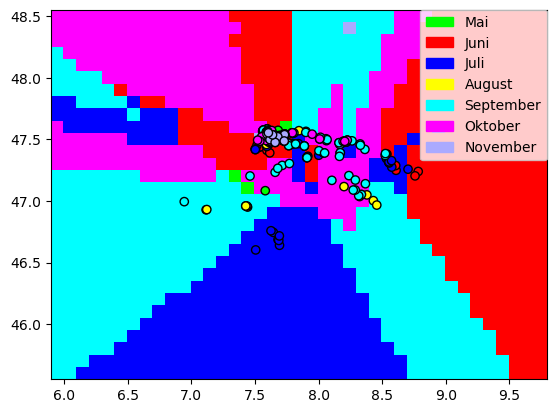

Classification Report: 
               precision    recall  f1-score   support

           1       0.10      0.17      0.12         6
           2       0.23      0.33      0.27         9
           3       0.50      0.30      0.37        10
           4       0.30      0.33      0.32         9
           5       0.50      0.47      0.48        15
           6       0.17      0.12      0.14         8
           7       0.00      0.00      0.00         3

    accuracy                           0.30        60
   macro avg       0.26      0.25      0.24        60
weighted avg       0.32      0.30      0.30        60



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

# Lesen Sie die CSV-Datei
df = pd.read_csv('coordinates.csv', header=None, names=['Latitude', 'Longitude', 'Month'])

# Monate in numerische Werte umwandeln
months = {'Mai':1, 'Juni':2, 'Juli':3, 'August':4, 'September':5, 'Oktober':6, 'November':7}
df['Month'] = df['Month'].map(months)

# Duplikate entfernen
df = df.drop_duplicates()

# Variablen festlegen
X = df[['Longitude', 'Latitude']].values
y = df['Month']

# Aufteilen der Daten in Training- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# K-Nearest Neighbors Modell erstellen

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Bereiche zeichnen
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

colors_list = ['#00FF00', '#FF0000', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#AAAAFF']
cmap_light = ListedColormap(colors_list)

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Farben mit Monaten im Legendenfeld verknüpfen
patches = [mpatches.Patch(color=colors_list[i], label=month) for i, month in enumerate(months)]
plt.legend(handles=patches, loc='upper right', borderaxespad=0.)

plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', cmap=cmap_light)
plt.show()

# Vorhersagen auf den Testdaten generieren
y_pred = knn.predict(X_test)

# Auswertung des Modells
report = classification_report(y_test, y_pred)
print("Classification Report: \n", report)

<iframe src="https://www.google.com/maps/d/embed?mid=1apMhJHAyxVrtAY3oitbtkdKem6wQyLE&hl=de&ehbc=2E312F" width="640" height="480"></iframe>
